In [1]:
import random
import array
import time

import numpy as np

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#@title Hyperparameters
NDIM = 6
CR = 0.25
F = 1
MU = 300
NGEN = 1000
GEN_OUTPUT = 25
MAX_TIME = 5

In [3]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

In [4]:
#@title Add Genetic Operators to Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -3, 3)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selRandom, k=3)

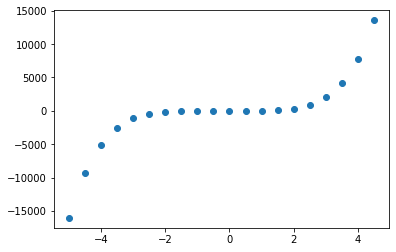

In [6]:
#@title Generate regression data
equation_form = "polynomial" #@param ["polynomial", "abs", "step"]

X_START = -5
X_END = 5
X_STEP = 0.5

def equation(x):
  if equation_form == "polynomial":
    return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)
  elif equation_form == "abs":
    return abs(x)
  else:
    return np.where(x>1, 1, 0)

X = np.array([x for x in np.arange(X_START, X_END, X_STEP)])
Y = equation(X)
data = list(zip(X, Y))

plt.scatter(X,Y)

In [7]:
#@title Evaluation of fitness
def pred(ind, x):
  y_ = 0.0
  for i in range(1,NDIM):
    y_ += ind[i-1]*x**i
  y_ += ind[NDIM-1]
  return y_

def fitness(ind, data):
  mse = 0.0
  for x, y in data:
    y_ = pred(ind, x)
    mse += (y - y_)**2
  return mse/len(data),

# fitness eval
toolbox.register("evaluate", fitness, data=data)

In [8]:
#@title Plot Fitness
def plot_fitness(g, best, pop, logbook):
  Y_ = np.array([pred(best, x) for x in X])
  clear_output()
  print(f"Generation {g}, Best {best}")
  print(logbook.stream)
  fits = [f.fitness.values[0] for f in pop]
  plt.hist(fits)
  plt.show()
  plt.scatter(X,Y)
  plt.plot(X,Y_, 'r')
  plt.show()

Generation 274, Best Individual('d', [-3.5128642214250547, 10.24113291608553, 5.3163747546334115, 4.66888517457846, 5.947969415866613, -18.960755374519422])
250	300  	7080.82    	310.61     	7986.74    	58487.7    
251	300  	7027.93    	310.61     	7901.73    	58487.7    
252	300  	7027.64    	310.61     	7894.64    	58487.7    
253	300  	7034.64    	310.61     	7870.81    	58487.7    
254	300  	7032.49    	310.61     	7823.94    	58487.7    
255	300  	7032.1     	310.61     	7741.28    	58487.7    
256	300  	6896.84    	310.61     	7674.72    	56018.9    
257	300  	6902.5     	310.61     	7661.49    	56018.9    
258	300  	6904.93    	310.61     	7624.86    	56018.9    
259	300  	6916.25    	310.61     	7594.74    	56018.9    
260	300  	6900.86    	310.61     	7563.2     	56018.9    
261	300  	6902.61    	310.61     	7477.93    	56018.9    
262	300  	6842.61    	310.61     	7410.04    	56018.9    
263	300  	6553.63    	310.61     	7293.57    	56018.9    
264	300  	6547.21    	310.61   

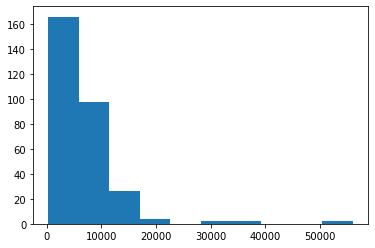

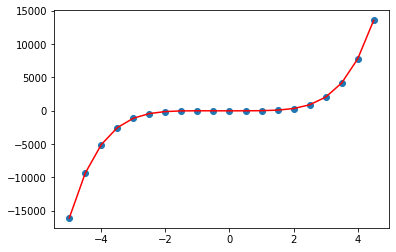

Best individual is  Individual('d', [-3.5128642214250547, 10.24113291608553, 5.3163747546334115, 4.66888517457846, 5.947969415866613, -18.960755374519422]) 310.6099532907916


In [9]:

pop = toolbox.population(n=MU);
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

# Evaluate the individuals
fitnesses = toolbox.map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

record = stats.compile(pop)
logbook.record(gen=0, evals=len(pop), **record)
print(logbook.stream)
start = time.time()
for g in range(1, NGEN):
  for k, agent in enumerate(pop):
    a,b,c = toolbox.select(pop)
    y = toolbox.clone(agent)
    index = random.randrange(NDIM)
    for i, value in enumerate(agent):
      if i == index or random.random() < CR:
        y[i] = a[i] + F*(b[i]-c[i])
    y.fitness.values = toolbox.evaluate(y)
    if y.fitness > agent.fitness:
      pop[k] = y
  hof.update(pop)
  record = stats.compile(pop)
  logbook.record(gen=g, evals=len(pop), **record)
  if (g+1) % GEN_OUTPUT == 0:
    plot_fitness(g, hof[0], pop, logbook)
    end = time.time()
    if end-start > MAX_TIME:
      break

print("Best individual is ", hof[0], hof[0].fitness.values[0])